In [1]:
import json

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import ipywidgets

from stellarpunk import util

# Loading and Preparing Data

In [2]:
df_base = pd.read_json("/tmp/stellarpunk_test.test_more_cbdr.history.gz", lines=True)
df_base = df_base.join(pd.json_normalize(df_base["o"]).add_prefix("o."))

In [3]:
e_types = df_base.groupby("eid")["p"].min()

In [4]:
eids = pd.Series(df_base["eid"].unique())
eids

0     a46dcc10-4d3e-4195-b95f-cb50255f89b3
1     ec157d16-3118-40df-b841-0f0f95aeda35
2     2ed2c9d9-b2bf-40ea-a3a5-b266fe18f398
3     46cf27c6-6306-4c5b-a7a3-0547b3639a54
4     b9d056dc-2963-405f-9c4b-f316fc6aefc4
5     f1df2797-9e94-4a66-be88-b426b599d411
6     0e756bb5-6ada-42e7-8e96-838a8c363a35
7     2a956337-25bb-4f9e-b354-6df11516b30b
8     be65937c-609f-43bf-baeb-536df3244fe3
9     3d62105c-3610-4ddd-b70c-17598038a44f
10    6080a43c-bbe0-4e93-a45b-3bde7e368d02
11    54010d78-870b-4db4-a472-c93e895c57d9
12    8cb966ec-a4d0-4c01-9e83-9b8345db6f22
13    c3a8538a-b474-4c95-9085-5d0e629ad295
14    e0119b5b-de77-4705-88eb-773cae5d2613
15    8b2bb8a5-a1bc-48b5-a136-86433db97b05
16    dd34c2db-7181-4213-b461-7a0564ad3828
17    4058c39f-26fa-4d31-9110-c1fb68c4be18
18    9dd183a9-0a88-443c-8295-4835cd999f58
19    fe329901-7bdb-4908-90d0-eace93f37df5
20    9a4c1139-96e8-4650-bcad-ddf2a3f5d7fc
21    4100045b-22ca-4cfd-9702-d2d8c45c5175
22    c11d2ba4-a121-4f4b-a142-1e8f7d791c4a
23    aedd5

In [5]:
targets = eids[pd.Series(df_base["eid"].unique()).str.startswith("d936")]
targets

42    d9361e71-7095-4b77-97f5-af27d00f67f5
dtype: object

In [6]:
target_index = targets.index[0]

In [7]:
target_eid = df_base["eid"].unique()[target_index]
df_base = df_base[df_base["eid"] == target_eid].reset_index()
df_base["eid"].unique()

array(['d9361e71-7095-4b77-97f5-af27d00f67f5'], dtype=object)

In [8]:
e_types.loc[target_eid]

'SHP'

In [9]:
loc = pd.DataFrame(np.vstack(df_base["loc"]), columns=["loc.x", "loc.y"])
v = pd.DataFrame(np.vstack(df_base["v"]), columns=["v.x", "v.y"])

empty_array = np.empty(len(df_base))
empty_array[:] = np.nan

if "o.t_loc" in df_base:
    o_tloc = pd.DataFrame(np.vstack(df_base["o.t_loc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.t_loc.x", "o.t_loc.y"])
    o_tv = pd.DataFrame(np.vstack(df_base["o.t_v"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.t_v.x", "o.t_v.y"])
    o_dv = pd.DataFrame(np.vstack(df_base["o._dv"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o._dv.x", "o._dv.y"])
    desired_angle = df_base.apply(lambda x: util.cartesian_to_polar(*(np.array(x["o._dv"]) - np.array(x["v"])))[1], axis=1)
    df_base["o._ada"] = desired_angle
    o_ada = desired_angle = pd.DataFrame(np.vstack(df_base.apply(lambda row: np.array(util.polar_to_cartesian(100, row["o._ada"])), axis=1)), columns=["_ada.x", "_ada.y"])
else:
    o_tloc = pd.DataFrame({"o.t_loc": empty_array, "o.t_loc.x": empty_array, "o.t_loc.y": empty_array})
    o_tv = pd.DataFrame({"o.t_v": empty_array, "o.t_v.x": empty_array, "o.t_v.y": empty_array})
    o_dv = pd.DataFrame({"o._dv": empty_array, "o._dv.x": empty_array, "o._dv.y": empty_array})
    o_ada = pd.DataFrame({"o._ada": empty_array, "o._ada.x": empty_array, "o._ada.y": empty_array})
    
if "o.ct" in df_base:
    o_ctloc = pd.DataFrame(np.vstack(df_base["o.ct_loc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.ct_loc.x", "o.ct_loc.y"])
    o_ctdv = pd.DataFrame(np.vstack(df_base["o.ct_dv"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.ct_dv.x", "o.ct_dv.y"])
    o_ctv = pd.DataFrame(np.vstack(df_base["o.ct_v"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.ct_v.x", "o.ct_v.y"])
    o_ctcloc = pd.DataFrame(np.vstack(df_base["o.ct_cloc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.ct_cloc.x", "o.ct_cloc.y"])
else:
    o_ctloc = pd.DataFrame({"o.ct_loc": empty_array, "o.ct_loc.x": empty_array, "o.ct_loc.y": empty_array})
    o_ctdv = pd.DataFrame({"o.ct_dv": empty_array, "o.ct_dv.x": empty_array, "o.ct_dv.y": empty_array})
    o_ctv = pd.DataFrame({"o.ct_v": empty_array, "o.ct_v.x": empty_array, "o.ct_v.y": empty_array})
    o_ctcloc = pd.DataFrame({"o.ct_cloc": empty_array, "o.ct_cloc.x": empty_array, "o.ct_cloc.y": empty_array})
angle = pd.DataFrame(np.vstack(df_base.apply(lambda row: np.array(util.polar_to_cartesian(100, row["a"])), axis=1)), columns=["angle.x", "angle.y"])
df = pd.concat([df_base, loc, v, o_ctloc, o_ctcloc, o_ctdv, o_ctv, o_tloc, o_tv, o_dv, angle, o_ada], axis=1)

if "o.ct" not in df_base:
    df["o.ct"] = empty_array
    df["o.ct_ts"] = empty_array
    df["o.cac"] = empty_array
    df["o.cbdr"] = empty_array
    df["o.cbdr_hist"] = empty_array
    df["o.ct_ct"] = empty_array
    df["o.ct_cradius"] = empty_array
    df["o.nd"] = empty_array
    df["o.ct_dist"] = empty_array
    df["o.ct_cn"] = empty_array
    df["o.ct_ms"] = empty_array
    df["o.ct_mh"] = empty_array
    
else:
    df["o.ct_dist"] = np.linalg.norm(np.vstack(df["loc"]) - np.vstack(df["o.ct_cloc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), axis=1)
    
if "o.t_loc" not in df_base:
    df["o.cs"] = empty_array
    df["o.t_dist"] = empty_array
    df["o.msc"] = empty_array
    df["o.max_speed_cap"] = empty_array
else:
    df["o.t_dist"] = np.linalg.norm(np.vstack(df["loc"]) - np.vstack(df["o.t_loc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), axis=1)
    df["o.max_speed_cap"] = (df["o.msc"]*(1+df["o.msc_a"])**(df["ts"] - df["o.msc_ts"])).clip(upper=3000)
    
    


In [10]:
df["speed"] = np.linalg.norm(df[["v.x", "v.y"]], axis=1)
df["o.t_speed"] = np.linalg.norm(df[["o.t_v.x", "o.t_v.y"]], axis=1)
df["o._dv_speed"] = np.linalg.norm(df[["o._dv.x", "o._dv.y"]], axis=1)
df["f_mag"] = df["f"].apply(lambda x:np.linalg.norm(x))

In [11]:
df.iloc[-1]["o"]

{'o': 'stellarpunk.orders.movement.GoToLocation',
 'msc': 100.0,
 'msc_ts': 6.266666666666654,
 'msc_a': 0.2,
 'nn': 1,
 'nnd': 47.44553486437387,
 'ct': '1ec47e4b-5f71-4c0b-bd11-7b78b2bfff8f',
 'ct_ms': 33.81858627804542,
 'ct_loc': [-45209.1171875, 105712.0078125],
 'ct_v': [1980.7904052734375, 2.253388166427612],
 'ct_ts': 0.533333333333333,
 'ct_at': 0.06375995722939701,
 'ct_ct': 1,
 'ct_cloc': [-45082.82421875, 105712.1484375],
 'ct_cradius': 30.0,
 'ct_cn': [[-45209.11844668821, 105712.00678307227]],
 'ct_mh': 0.0,
 'cac': False,
 'cach': True,
 'cbdr': False,
 'cbdr_hist': [[-109.36030592741008, -616.9325476411032],
  [27.778097903625167, -38.4636978906492]],
 'ct_dv': [-3953840.25, 5474792.0],
 't_loc': [137771.765625, 51021.7578125],
 'ad': 4650.0,
 'md': 0.0,
 't_v': [95.80764770507812, -28.651262283325195],
 'cs': False,
 'scm': 60.0,
 '_ncts': 6.3523809523809405,
 '_dv': [-3951946.75, 5474279.5]}

# Basic Ship Vitals

## Position and Heading

In [12]:
def plot_location_chart(max_time):
    sample = df[df["ts"] <= max_time].iloc[::50]
    plt.quiver(sample["loc.x"], sample["loc.y"], sample["angle.x"], sample["angle.y"])#, scale=100)
    plt.scatter(sample["o.t_loc.x"], sample["o.t_loc.y"])
    #center = (0,2500)
    #radius = 10000
    #plt.xlim(center[0]-radius,center[0]+radius)
    #plt.ylim(center[1]-radius,center[1]+radius)

ipywidgets.interact(plot_location_chart, max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max(), continuous_update=False))

interactive(children=(FloatSlider(value=6.299999999999987, continuous_update=False, description='max_time', ma…

<function __main__.plot_location_chart(max_time)>

In [13]:
df[["loc.x", "loc.y"]].describe()

,loc.x,loc.y
count,189.000000,189.000000
mean,-51441.467841,107454.240906
std,3678.100838,1025.206095
min,-57759.820312,105750.468750
25%,-54624.664062,106564.390625
50%,-51415.035156,107426.039062
75%,-48237.410156,108326.281250
max,-45236.898438,109265.179688


Text(0.5, 1.0, 'position')

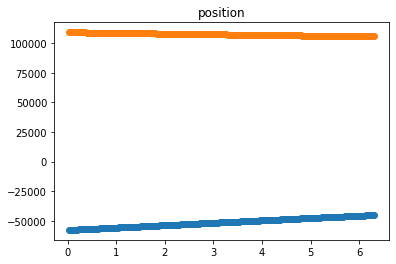

In [14]:
plt.scatter(df["ts"], df["loc.x"])
plt.scatter(df["ts"], df["loc.y"])
plt.title("position")

In [15]:
def plot_heading(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], sample["a"].apply(lambda x: util.normalize_angle(x, shortest=True)), label="theta")
    plt.scatter(sample["ts"], sample["av"], label="omega")
    plt.scatter(sample["ts"], sample["o._ada"].apply(lambda x: util.normalize_angle(x, shortest=True)), label="desired theta")
    plt.hlines(np.pi, sample["ts"].min(), sample["ts"].max(), color="red")
    plt.hlines(0, sample["ts"].min(), sample["ts"].max(), color="red")
    plt.legend()
    plt.title("heading and angular velocity")
    
ipywidgets.interact(plot_heading, hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False), max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=6.266666666666654, continuous_update=False, description='hist_length',…

<function __main__.plot_heading(hist_length, max_time)>

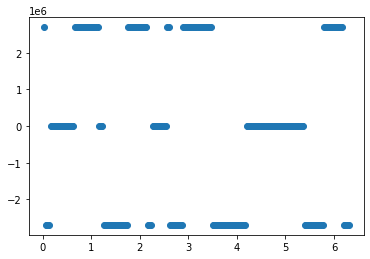

In [16]:
plt.scatter(df["ts"], df["t"])

In [17]:
(df["t"] == 0).value_counts()

False    126
True      63
Name: t, dtype: int64

In [18]:
((df["t"].abs() == 2700000.0) | (df["t"] == 0)).value_counts()

True    189
Name: t, dtype: int64

### Velocity and Acceleration

In [19]:
def plot_speed(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], sample["speed"])
    plt.title("speed")
    print(f'min speed: {sample["speed"].min()}')
    print(f'max speed: {sample["speed"].max()}')
    
ipywidgets.interact(plot_speed, hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False), max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=6.266666666666654, continuous_update=False, description='hist_length',…

<function __main__.plot_speed(hist_length, max_time)>

In [20]:
def plot_velocity(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], sample["v.x"], label="x")
    plt.scatter(sample["ts"], sample["v.y"], label="y")
    plt.legend()
    plt.title("velocity")
    
ipywidgets.interact(plot_velocity, hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False), max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=6.266666666666654, continuous_update=False, description='hist_length',…

<function __main__.plot_velocity(hist_length, max_time)>

In [21]:
def plot_acceleration(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], (sample["v.x"].shift(1) - sample["v.x"]) / (sample["ts"].shift(1) - sample["ts"]), label="x")
    plt.scatter(sample["ts"], (sample["v.y"].shift(1) - sample["v.y"]) / (sample["ts"].shift(1) - sample["ts"]), label="y")
    plt.yscale("symlog")
    plt.legend()
    plt.title("acceleration")
    
ipywidgets.interact(plot_acceleration, hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False), max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=6.266666666666654, continuous_update=False, description='hist_length',…

<function __main__.plot_acceleration(hist_length, max_time)>

In [22]:
def plot_force(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], sample["f_mag"])
    plt.yscale("log")
    plt.title("force")
    print(f'min force={sample["f_mag"].min()}')
    print(f'max force={sample["f_mag"].max()}')

ipywidgets.interact(plot_force, hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False), max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=6.266666666666654, continuous_update=False, description='hist_length',…

<function __main__.plot_force(hist_length, max_time)>

# Behavior Monitoring

In [23]:
[next((df.iloc[idx]["ts"] if idx is not None else None for idx, v in zip(df.index, (~df[c].isna() & df[c] == True)) if v), None) for c in ["o.ct", "o.cs", "o.cac", "o.cbdr"]]

[0.5666666666666661, None, 2.8666666666666663, 1.166666666666667]

In [24]:
def plot_collision_info(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], (~(sample["o.ct"].isna())).astype(int), label="ct")
    plt.scatter(sample["ts"], sample["o.cs"].fillna(0).astype(int)+0.05, label="cs")
    plt.scatter(sample["ts"], sample["o.cac"].fillna(0).astype(int)+0.1, label="cac")
    plt.scatter(sample["ts"], sample["o.cbdr"].fillna(0).astype(int)+0.15, label="cbdr")
    plt.scatter(sample["ts"], sample["o.cach"].fillna(0).astype(int)+0.1, label="cach", marker="+")
    plt.legend()
    plt.title("status flags")
    
    flag_cols = ["o.ct", "o.cs", "o.cac", "o.cach", "o.cbdr"]
    first_ts = [
        next(
            (sample.loc[idx]["ts"] if idx is not None else None
             for idx, v in zip(sample.index, (~sample[c].isna() & sample[c] == True))
             if v),
            None
        )
        for c in flag_cols
    ]
    for c, ts in zip(flag_cols, first_ts):
        print(f'first {c}: {ts}')

ipywidgets.interact(plot_collision_info, hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False), max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=6.266666666666654, continuous_update=False, description='hist_length',…

<function __main__.plot_collision_info(hist_length, max_time)>

### Target Location

In [25]:
if np.any(~df["o.t_loc"].isna()):
    x = df.groupby(["o.t_loc.x", "o.t_loc.y"]).agg({"ts": ["count", "min", "max"], "o.t_dist": ["min","max"], "o.ad":["min"]})
else:
    x = "no location target"
x

ts                      o.t_dist                \
                           count       min  max            min           max   
o.t_loc.x     o.t_loc.y                                                        
137771.765625 51021.757812   189  0.033333  6.3  191016.760843  204021.80592   

                              o.ad  
                               min  
o.t_loc.x     o.t_loc.y             
137771.765625 51021.757812  4650.0

In [26]:
#sample = df[(df["ts"] < 124.4) & (df["ts"] > 120)]
def plot_target_distance(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], sample["o.t_dist"])
    plt.scatter(sample["ts"], sample["o.ad"], color="green", marker="_")
    plt.scatter(sample["ts"], sample["o.md"], color="red", marker="_")
    #plt.ylim(0,1500)
    plt.title("distance to target")
    print(f'when first arrived {sample[sample["o.t_dist"] < sample["o.ad"]]["ts"].min()}')

ipywidgets.interact(
    plot_target_distance,
    hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=6.266666666666654, continuous_update=False, description='hist_length',…

<function __main__.plot_target_distance(hist_length, max_time)>

In [27]:
df[df["o.t_dist"] < df["o.ad"]]["ts"].min()

nan

In [28]:
def plot_desired_speed(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], sample["speed"], label="actual speed")
    plt.scatter(sample["ts"], sample["o.t_speed"], label="desired speed")
    plt.scatter(sample["ts"], sample["o.max_speed_cap"], label="max speed cap")
    plt.scatter(sample["ts"], sample["o._dv_speed"].apply(lambda x: x if x < 4000. else 4000.), label="desired speed (_dv)")
    plt.legend()
    plt.title("speed and desired speed to target")
    plt.ylim(0)

ipywidgets.interact(
    plot_desired_speed,
    hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=6.266666666666654, continuous_update=False, description='hist_length',…

<function __main__.plot_desired_speed(hist_length, max_time)>

Text(0.5, 1.0, 'desired speed delta')

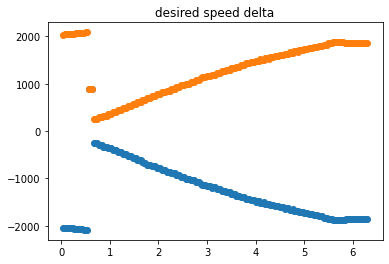

In [29]:
plt.scatter(df["ts"], df["o.t_speed"] - df["speed"])
plt.scatter(df["ts"], np.linalg.norm(np.array((df["o.t_v.x"] - df["v.x"], df["o.t_v.y"] - df["v.y"])), axis=0))
plt.title("desired speed delta")

## Collision Avoidance

### Collision Threats

In [30]:
def show_collision_threats(hist_length, max_time):
    sample = df[(df["ts"] >= max_time-hist_length) & (df["ts"] <= max_time)]
    if np.any(~sample["o.ct"].isna()):
        x = sample.groupby("o.ct").agg({"ts": ["count", "min", "max"], "o.ct_dist": ["min","max"]})
    else:
        x = "no collision threats"
    return x
ipywidgets.interact(
    show_collision_threats,
    hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False)
)

interactive(children=(FloatSlider(value=6.266666666666654, continuous_update=False, description='hist_length',…

<function __main__.show_collision_threats(hist_length, max_time)>

In [31]:
e_types.loc[df[~df["o.ct"].isna()]["o.ct"].unique()]

eid
1ec47e4b-5f71-4c0b-bd11-7b78b2bfff8f    SHP
Name: p, dtype: object

In [32]:
def plot_collision_distance(hist_length, max_time):
    sample = df[(df["ts"] >= max_time-hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], sample["o.ct_dist"])
    plt.scatter(sample["ts"], sample["o.ct_cradius"]+sample["o.scm"]*2, color="green", marker="_")
    plt.scatter(sample["ts"], sample["o.ct_cradius"]+sample["o.scm"], color="orange", marker="_")
    plt.scatter(sample["ts"], sample["o.ct_cradius"], color="red", marker="_")
    plt.hlines(60, sample["ts"].min(), sample["ts"].max(), color="red")
    plt.ylim(0)
    plt.title("distance to collision threat")
    print(f'max ct dist: {sample["o.ct_dist"].max()}')
    print(f'min ct dist: {sample["o.ct_dist"].min()}')

ipywidgets.interact(
    plot_collision_distance,
    hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False)
)

interactive(children=(FloatSlider(value=6.266666666666654, continuous_update=False, description='hist_length',…

<function __main__.plot_collision_distance(hist_length, max_time)>

In [33]:
def plot_minimum_separation(hist_length, max_time):
    sample = df[(df["ts"] >= max_time-hist_length) & (df["ts"] <= max_time)]
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.scatter(sample["ts"], sample["o.ct_ms"])
    ax2.scatter(sample["ts"], sample["o.ct_at"], color="orange")
    #plt.scatter(sample["ts"], sample["o.ct_cradius"]+30, color="red", marker="_")
    plt.ylim(0)
    plt.title("minimum_separation with collision threat")
    print(f'min sep: {sample["o.ct_ms"].min(), sample["o.ct_ms"].max()}')
    print(f'approach time: {sample["o.ct_at"].min(), sample["o.ct_at"].max()}')

ipywidgets.interact(
    plot_minimum_separation,
    hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False)
)

interactive(children=(FloatSlider(value=6.266666666666654, continuous_update=False, description='hist_length',…

<function __main__.plot_minimum_separation(hist_length, max_time)>

In [34]:
def plot_threat_age(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    ax1.scatter(sample["ts"], 1-sample["o.ct"].isna().astype(int))
    ax2.scatter(sample["ts"], sample["ts"] - sample["o.ct_ts"], color="orange")
    plt.title("Collision Threat and Time Since Detection")

    #ax2.set_ylim(0,(df["ts"] - df["o.ct_ts"]).max()*1.2)
    
ipywidgets.interact(
    plot_threat_age,
    hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=6.266666666666654, continuous_update=False, description='hist_length',…

<function __main__.plot_threat_age(hist_length, max_time)>

## CBDR Detection

In [35]:
def plot_cbdr_detection_data(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    
    max_delta_bearing = 2e-3
    min_delta_range = 5

    bearing = sample["o.cbdr_hist"].apply(lambda x: np.nan if isinstance(x, float) or len(x) < 2 else abs(util.cartesian_to_polar(x[0][0], x[0][1])[1] - util.cartesian_to_polar(x[-1][0], x[-1][1])[1]))
    threat_range = sample["o.cbdr_hist"].apply(lambda x: np.nan if isinstance(x, float) or len(x) < 2 else util.cartesian_to_polar(x[0][0], x[0][1])[0] - util.cartesian_to_polar(x[-1][0], x[-1][1])[0])
    ax1.scatter(sample["ts"], bearing, label="delta bearing")
    ax1.hlines(max_delta_bearing, sample["ts"].min(), sample["ts"].max(), color="green", label="max delta bearing")
    ax2.scatter(sample["ts"], threat_range, color="orange", label="delta range")
    ax2.hlines(min_delta_range, sample["ts"].min(), sample["ts"].max(), color="red", label="min delta range")
    fig.legend()
    
    print(f'{max_delta_bearing=}, bearing:\t{(bearing.min(),bearing.max())}')
    print(f'{min_delta_range=}, range:\t{(threat_range.min(),threat_range.max())}')
    
ipywidgets.interact(
    plot_cbdr_detection_data,
    hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=6.266666666666654, continuous_update=False, description='hist_length',…

<function __main__.plot_cbdr_detection_data(hist_length, max_time)>

In [36]:
df[["ts","o.cbdr_hist"]].tail(50)

,ts,o.cbdr_hist
139,4.666667,"[[-351.38611738348845, -1561.652796598879], [-..."
140,4.700000,"[[-339.79515750618157, -1504.8186799032555], [..."
141,4.733333,"[[-339.79515750618157, -1504.8186799032555], [..."
142,4.766667,"[[-339.79515750618157, -1504.8186799032555], [..."
143,4.800000,"[[-328.20652875615633, -1448.003228952046], [-..."
144,4.833333,"[[-328.20652875615633, -1448.003228952046], [-..."
145,4.866667,"[[-328.20652875615633, -1448.003228952046], [-..."
146,4.900000,"[[-316.620249582651, -1391.2065374882513], [-1..."
147,4.933333,"[[-316.620249582651, -1391.2065374882513], [-1..."
148,4.966667,"[[-316.620249582651, -1391.2065374882513], [-1..."


In [37]:
def plot_num_coalesced_threats(hist_length, max_time):
    sample = df[(df["ts"] >= max_time-hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], sample["o.ct_ct"])
    plt.title("number of coalesced threats")
    plt.show()

ipywidgets.interact(
    plot_num_coalesced_threats,
    hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False)
)  

interactive(children=(FloatSlider(value=6.266666666666654, continuous_update=False, description='hist_length',…

<function __main__.plot_num_coalesced_threats(hist_length, max_time)>

In [38]:
def plot_collision_threat_radius(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], sample["o.ct_cradius"], label="threat radius")
    plt.scatter(sample["ts"], sample["o.scm"]+sample["o.ct_mh"], label="desired margin")
    plt.title("collision threat radius")
    plt.legend()
    print(f'min coalesced radius: {sample["o.ct_cradius"].min()}')
    print(f'min scaled margin: {sample["o.scm"].min()}')
    plt.show()

ipywidgets.interact(
    plot_collision_threat_radius,
    hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=6.266666666666654, continuous_update=False, description='hist_length',…

<function __main__.plot_collision_threat_radius(hist_length, max_time)>

In [39]:
def plot_collision_threat_loc(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.scatter(sample["ts"], sample["o.ct_cloc.x"])
    ax2.scatter(sample["ts"], sample["o.ct_cloc.y"], color="orange")
    plt.title("collision threat coalesced location")
    plt.show()

ipywidgets.interact(
    plot_collision_threat_loc,
    hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=6.266666666666654, continuous_update=False, description='hist_length',…

<function __main__.plot_collision_threat_loc(hist_length, max_time)>

In [40]:
df[(df["o.ct_cloc.x"]-df["o.ct_cloc.x"].shift(1)).abs() > 30]

,index,p,eid,ts,loc,r,a,v,av,f,...,angle.y,_ada.x,_ada.y,o.ct_dist,o.t_dist,o.max_speed_cap,speed,o.t_speed,o._dv_speed,f_mag
43,2371,SHP,d9361e71-7095-4b77-97f5-af27d00f67f5,1.466667,"[-54894.66015625, 108405.578125]",30,0.474383,"[2020.638916015625, -597.2120361328125]",0.890879,"[173624.11530979103, 99270.67332748574]",...,45.678924,86.812057,49.635338,9370.649522,201030.481413,1546.292775,2107.046237,1536.923875,2.605678e+03,200000.0
46,2374,SHP,d9361e71-7095-4b77-97f5-af27d00f67f5,1.566667,"[-54692.30859375, 108346.0234375]",30,0.553470,"[2029.320068359375, -592.24853515625]",0.590879,"[174424.67491258477, 97857.20607926183]",...,52.564268,87.212336,48.928605,9285.204381,200819.549084,1506.802655,2113.976884,1497.672998,2.566621e+03,200000.0
49,2377,SHP,d9361e71-7095-4b77-97f5-af27d00f67f5,1.666667,"[-54489.0859375, 108286.9609375]",30,0.602558,"[2038.041259765625, -587.3556518554688]",0.290879,"[175192.41985779995, 96475.98677582077]",...,56.675207,87.596213,48.237989,9185.160799,200607.922407,1467.903084,2120.990061,1459.009131,2.524488e+03,200000.0
52,2380,SHP,d9361e71-7095-4b77-97f5-af27d00f67f5,1.766667,"[-54284.98828125, 108228.390625]",30,0.621646,"[2046.8009033203125, -582.5318603515625]",-0.009121,"[7864.274079867912, 12773.143434437652]",...,58.237415,52.428495,85.154289,9068.782994,200395.597653,1429.577166,2128.083012,1420.915450,2.602028e+03,15000.0
82,2410,SHP,d9361e71-7095-4b77-97f5-af27d00f67f5,2.766667,"[-52236.5390625, 107649.3984375]",30,1.402525,"[2051.86767578125, -566.6776123046875]",0.690879,"[57586.42686777173, 191530.16326574457]",...,98.587575,28.793213,95.765082,7101.865790,198267.106533,1058.774454,2128.681394,1052.359385,1.267051e+10,200000.0
85,2413,SHP,d9361e71-7095-4b77-97f5-af27d00f67f5,2.866667,"[-52031.25390625, 107593.046875]",30,1.461613,"[2054.746826171875, -557.1011352539062]",0.390879,"[4798.9267679456925, 14211.625588788014]",...,99.404541,31.992845,94.744171,6955.231964,198054.277837,1022.584825,2128.930763,1016.389010,1.221570e+10,15000.0
86,2414,SHP,d9361e71-7095-4b77-97f5-af27d00f67f5,2.900000,"[-51962.76171875, 107574.4765625]",30,1.474642,"[2054.826904296875, -556.8642578125]",0.290879,"[-14558.354565794229, 3613.075191110523]",...,99.538075,-97.055698,24.087163,7105.929870,197983.334815,987.043324,2128.946079,981.062894,1.793736e+03,15000.0


In [41]:
ctxloc_diff_s = (df["o.ct_cloc.x"]-df["o.ct_cloc.x"].shift(1)).abs()
ctxloc_diff_s[ctxloc_diff_s > 30]

43    176.160156
46    130.472656
49    116.050781
52     99.886719
82     66.917969
85     67.910156
86    226.867188
Name: o.ct_cloc.x, dtype: float64

In [42]:
def plot_collision_dv(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], sample["o.ct_dv.x"])
    plt.scatter(sample["ts"], sample["o.ct_dv.y"])
    plt.title("collision avoidance velocity")

ipywidgets.interact(
    plot_collision_dv,
    hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=6.266666666666654, continuous_update=False, description='hist_length',…

<function __main__.plot_collision_dv(hist_length, max_time)>

In [43]:
df[(df["o.ct_dv.x"]-df["o.ct_dv.x"].shift(1)).abs() > 250]

,index,p,eid,ts,loc,r,a,v,av,f,...,angle.y,_ada.x,_ada.y,o.ct_dist,o.t_dist,o.max_speed_cap,speed,o.t_speed,o._dv_speed,f_mag
19,2347,SHP,d9361e71-7095-4b77-97f5-af27d00f67f5,0.666667,"[-56504.609375, 108888.0]",30,-0.268321,"[2014.0048828125, -604.5323486328125]",-0.009121,"[-13024.840506353446, 7439.995281184962]",...,-26.511246,-86.832269,49.599971,10861.965870,202711.153783,1865.166148,2102.777931,1853.865237,1.608760e+03,15000.0
34,2362,SHP,d9361e71-7095-4b77-97f5-af27d00f67f5,1.166667,"[-55498.37890625, 108586.140625]",30,0.077119,"[2010.638671875, -602.8902587890625]",1.490879,"[12921.7656244039, 7617.609411618164]",...,7.704244,86.145104,50.784062,9819.600437,201660.623166,1665.613363,2099.081831,1655.521544,2.645554e+03,15000.0
79,2407,SHP,d9361e71-7095-4b77-97f5-af27d00f67f5,2.666667,"[-52441.5546875, 107706.7109375]",30,1.313437,"[2049.299072265625, -576.3421630859375]",0.990879,"[51370.220734189956, 193290.19742791046]",...,96.706550,25.685110,96.645099,7248.971723,198479.951469,1095.240379,2128.801770,1088.604326,1.315070e+10,200000.0
82,2410,SHP,d9361e71-7095-4b77-97f5-af27d00f67f5,2.766667,"[-52236.5390625, 107649.3984375]",30,1.402525,"[2051.86767578125, -566.6776123046875]",0.690879,"[57586.42686777173, 191530.16326574457]",...,98.587575,28.793213,95.765082,7101.865790,198267.106533,1058.774454,2128.681394,1052.359385,1.267051e+10,200000.0
85,2413,SHP,d9361e71-7095-4b77-97f5-af27d00f67f5,2.866667,"[-52031.25390625, 107593.046875]",30,1.461613,"[2054.746826171875, -557.1011352539062]",0.390879,"[4798.9267679456925, 14211.625588788014]",...,99.404541,31.992845,94.744171,6955.231964,198054.277837,1022.584825,2128.930763,1016.389010,1.221570e+10,15000.0
86,2414,SHP,d9361e71-7095-4b77-97f5-af27d00f67f5,2.900000,"[-51962.76171875, 107574.4765625]",30,1.474642,"[2054.826904296875, -556.8642578125]",0.290879,"[-14558.354565794229, 3613.075191110523]",...,99.538075,-97.055698,24.087163,7105.929870,197983.334815,987.043324,2128.946079,981.062894,1.793736e+03,15000.0
161,2489,SHP,d9361e71-7095-4b77-97f5-af27d00f67f5,5.400000,"[-46946.51171875, 106213.890625]",30,2.911839,"[1902.5382080078125, -516.6884765625]",-0.009121,"[14837.009921578941, 2205.2520461317226]",...,22.773747,98.913401,14.701673,1894.191156,192787.482761,143.578520,1971.450891,142.708589,2.332434e+03,15000.0
173,2501,SHP,d9361e71-7095-4b77-97f5-af27d00f67f5,5.800000,"[-46184.953125, 106007.296875]",30,2.688191,"[1905.5037841796875, -516.235107421875]",-1.209121,"[-193112.91367771878, 52032.70674202852]",...,43.802632,-96.556457,26.016353,1127.897862,191998.655931,100.609589,1974.194357,100.000001,1.918938e+03,200000.0
185,2513,SHP,d9361e71-7095-4b77-97f5-af27d00f67f5,6.200000,"[-45426.2578125, 105801.75]",30,2.424542,"[1893.675537109375, -513.0484008789062]",-0.009121,"[-3108.9728735181634, 14674.272986138982]",...,65.716436,-20.726486,97.828487,354.533952,191212.874398,100.609589,1961.944368,100.000004,2.540021e+07,15000.0
188,2516,SHP,d9361e71-7095-4b77-97f5-af27d00f67f5,6.300000,"[-45236.8984375, 105750.46875]",30,2.413630,"[1893.52001953125, -512.314697265625]",-0.309121,"[-8782.10133112846, 12160.374016032227]",...,66.535006,-58.547342,81.069160,158.768105,191016.760843,100.609589,1961.602512,100.000001,6.751712e+06,15000.0


## Nearest Neighbors

In [44]:
neighborhood_radius = 5e4
def plot_neighborhood_size(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], sample["o.nn"])
    plt.title("neighborhood size (10km^2)")
    plt.show()

ipywidgets.interact(
    plot_neighborhood_size,
    hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=6.266666666666654, continuous_update=False, description='hist_length',…

<function __main__.plot_neighborhood_size(hist_length, max_time)>

In [45]:
def plot_nearest_neighbor(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], sample["o.nnd"], label="nearest neighbor dist")
    plt.scatter(sample["ts"], sample["o.scm"], label="desired margin")
    plt.title("nearest neighor dist")
    plt.legend()
    plt.show()
    print(f'min dist {sample["o.nnd"].min()}')

ipywidgets.interact(
    plot_nearest_neighbor,
    hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=6.266666666666654, continuous_update=False, description='hist_length',…

<function __main__.plot_nearest_neighbor(hist_length, max_time)>

In [46]:
# 
# Smallest enclosing circle - Library (Python)
# 
# Copyright (c) 2020 Project Nayuki
# https://www.nayuki.io/page/smallest-enclosing-circle
# 
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
# 
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU Lesser General Public License for more details.
# 
# You should have received a copy of the GNU Lesser General Public License
# along with this program (see COPYING.txt and COPYING.LESSER.txt).
# If not, see <http://www.gnu.org/licenses/>.
# 

import math, random


# Data conventions: A point is a pair of floats (x, y). A circle is a triple of floats (center x, center y, radius).

# Returns the smallest circle that encloses all the given points. Runs in expected O(n) time, randomized.
# Input: A sequence of pairs of floats or ints, e.g. [(0,5), (3.1,-2.7)].
# Output: A triple of floats representing a circle.
# Note: If 0 points are given, None is returned. If 1 point is given, a circle of radius 0 is returned.
# 
# Initially: No boundary points known
def make_circle(points):
	# Convert to float and randomize order
	shuffled = [(float(x), float(y)) for (x, y) in points]
	random.shuffle(shuffled)
	
	# Progressively add points to circle or recompute circle
	c = None
	for (i, p) in enumerate(shuffled):
		if c is None or not is_in_circle(c, p):
			c = _make_circle_one_point(shuffled[ : i + 1], p)
	return c


# One boundary point known
def _make_circle_one_point(points, p):
	c = (p[0], p[1], 0.0)
	for (i, q) in enumerate(points):
		if not is_in_circle(c, q):
			if c[2] == 0.0:
				c = make_diameter(p, q)
			else:
				c = _make_circle_two_points(points[ : i + 1], p, q)
	return c


# Two boundary points known
def _make_circle_two_points(points, p, q):
	circ = make_diameter(p, q)
	left  = None
	right = None
	px, py = p
	qx, qy = q
	
	# For each point not in the two-point circle
	for r in points:
		if is_in_circle(circ, r):
			continue
		
		# Form a circumcircle and classify it on left or right side
		cross = _cross_product(px, py, qx, qy, r[0], r[1])
		c = make_circumcircle(p, q, r)
		if c is None:
			continue
		elif cross > 0.0 and (left is None or _cross_product(px, py, qx, qy, c[0], c[1]) > _cross_product(px, py, qx, qy, left[0], left[1])):
			left = c
		elif cross < 0.0 and (right is None or _cross_product(px, py, qx, qy, c[0], c[1]) < _cross_product(px, py, qx, qy, right[0], right[1])):
			right = c
	
	# Select which circle to return
	if left is None and right is None:
		return circ
	elif left is None:
		return right
	elif right is None:
		return left
	else:
		return left if (left[2] <= right[2]) else right


def make_diameter(a, b):
	cx = (a[0] + b[0]) / 2
	cy = (a[1] + b[1]) / 2
	r0 = math.hypot(cx - a[0], cy - a[1])
	r1 = math.hypot(cx - b[0], cy - b[1])
	return (cx, cy, max(r0, r1))


def make_circumcircle(a, b, c):
	# Mathematical algorithm from Wikipedia: Circumscribed circle
	ox = (min(a[0], b[0], c[0]) + max(a[0], b[0], c[0])) / 2
	oy = (min(a[1], b[1], c[1]) + max(a[1], b[1], c[1])) / 2
	ax = a[0] - ox;  ay = a[1] - oy
	bx = b[0] - ox;  by = b[1] - oy
	cx = c[0] - ox;  cy = c[1] - oy
	d = (ax * (by - cy) + bx * (cy - ay) + cx * (ay - by)) * 2.0
	if d == 0.0:
		return None
	x = ox + ((ax*ax + ay*ay) * (by - cy) + (bx*bx + by*by) * (cy - ay) + (cx*cx + cy*cy) * (ay - by)) / d
	y = oy + ((ax*ax + ay*ay) * (cx - bx) + (bx*bx + by*by) * (ax - cx) + (cx*cx + cy*cy) * (bx - ax)) / d
	ra = math.hypot(x - a[0], y - a[1])
	rb = math.hypot(x - b[0], y - b[1])
	rc = math.hypot(x - c[0], y - c[1])
	return (x, y, max(ra, rb, rc))


_MULTIPLICATIVE_EPSILON = 1 + 1e-14

def is_in_circle(c, p):
	return c is not None and math.hypot(p[0] - c[0], p[1] - c[1]) <= c[2] * _MULTIPLICATIVE_EPSILON


# Returns twice the signed area of the triangle defined by (x0, y0), (x1, y1), (x2, y2).
def _cross_product(x0, y0, x1, y1, x2, y2):
	return (x1 - x0) * (y2 - y0) - (y1 - y0) * (x2 - x0)

In [47]:
make_circle([(-55239.66796875, 48717.57421875), (-64420.64453125, 56283.35546875), (-64745.4375, 53056.1328125)])

(-59830.15625, 52500.46484375, 5948.348017811875)

In [48]:
def plot_radius_comparison(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    foo = sample["o.ct_cn"].apply(lambda x: np.nan if isinstance(x, float) else make_circle(x)[2]+30)
    plt.scatter(sample["ts"], sample["o.ct_cradius"], label="threat radius")
    plt.scatter(sample["ts"], sample["o.scm"], label="threat radius")
    plt.scatter(sample["ts"], foo, label="min radius", marker="x")
    plt.legend()
    plt.title("cradius vs smallest enclosing radius")
    plt.show()

ipywidgets.interact(
    plot_radius_comparison,
    hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=6.266666666666654, continuous_update=False, description='hist_length',…

<function __main__.plot_radius_comparison(hist_length, max_time)>

# History Visualization

## Position and Velocity

In [49]:
def plot_collision_chart(hist_length=df["ts"].max(), max_time=df["ts"].max(), sampling_interval=50, show_tloc=True, show_tv=True, show_ctdv=True, show_v=True, show_cn=True, show_all_cts=True, show_projected_v=True):
    plt.figure(figsize=(10, 10))
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)].iloc[::sampling_interval]
    scale = None
    if show_v:
        q = plt.quiver(sample["loc.x"], sample["loc.y"], sample["v.x"], sample["v.y"], scale=scale, units="inches", label="v")
        q._init()
        scale = q.scale
    ctdv_df = sample[~(sample["o.ct_dv"].isna())]
    if show_ctdv:
        q = plt.quiver(ctdv_df["loc.x"], ctdv_df["loc.y"], ctdv_df["o.ct_dv.x"], ctdv_df["o.ct_dv.y"], scale=scale, units="inches", label="ctdv", color="orange")
        q._init()
        scale = q.scale
    if show_tv:
        q = plt.quiver(sample["loc.x"], sample["loc.y"], sample["o.t_v.x"], sample["o.t_v.y"], scale=scale, units="inches", label="tv", color="purple")
        q._init()
        scale = q.scale
    
    
    if show_all_cts:
        ctv_df = sample
    else:
        ctv_df = sample[sample["o.ct"] == sample.iloc[-1]["o.ct"]]
    q = plt.quiver(ctv_df["o.ct_loc.x"], ctv_df["o.ct_loc.y"], ctv_df["o.ct_v.x"], ctv_df["o.ct_v.y"], scale=scale, units="inches", label="ctv", color="cyan")
    q._init()
    scale = q.scale
    
    if show_all_cts:
        cts = df["o.ct"].unique()
    else:
        cts = [sample.iloc[-1]["o.ct"]]
        
    cmap = plt.get_cmap('viridis')
    for x, c in zip(cts, cmap(np.linspace(0, 1, len(cts)))):
        if not isinstance(x, str):
            continue
        ct = sample[sample["o.ct"] == x]
        if len(ct) == 0:
            continue
        plt.scatter(ct["o.ct_loc.x"], ct["o.ct_loc.y"], color=c, label=x[:8])
        
        t_next = 10
        x, y = ct.iloc[-1]["o.ct_loc.x"], ct.iloc[-1]["o.ct_loc.y"]
        x_next, y_next = ct.iloc[-1]["o.ct_loc.x"]+ct.iloc[-1]["o.ct_v.x"]*t_next, ct.iloc[-1]["o.ct_loc.y"]+ct.iloc[-1]["o.ct_v.y"]*t_next
        if show_projected_v and not np.allclose((x, y), (x_next, y_next)):
            plt.axline((x,y),(x_next,y_next), marker = 'x', color=c, dashes=[2,2])
    
    cloc_df = sample#[~(sample["o.ct_cloc"].isna())]
    if not isinstance(cloc_df.iloc[-1]["o.ct"], float):
        cloc_x = cloc_df.iloc[-1]["o.ct_cloc.x"]
        cloc_y = cloc_df.iloc[-1]["o.ct_cloc.y"]
        cradius = cloc_df.iloc[-1]["o.ct_cradius"]
        cmargin = cloc_df.iloc[-1].get(["o.scm"],500)
        threat_radius = plt.Circle((cloc_x, cloc_y), cradius, color="red", fill=False)
        margin = plt.Circle((cloc_x, cloc_y), cradius+cmargin, color="orange", fill=False)
        margin_hist = plt.Circle((cloc_x, cloc_y), cradius+cmargin*2, color="green", fill=False)
        plt.gca().add_patch(threat_radius)
        plt.gca().add_patch(margin)
        plt.gca().add_patch(margin_hist)
        print(f'{cradius=}')
        
        if show_cn:
            cn_x, cn_y = list(zip(*cloc_df.iloc[-1]["o.ct_cn"]))
            plt.scatter(cn_x, cn_y, label="ct_cnloc", marker="+", color="pink")
    
    if show_tloc and not all(sample["o.t_loc.x"].isna()):
        plt.scatter(sample["o.t_loc.x"], sample["o.t_loc.y"], label="t_loc", marker="x")
        for ((tloc_x, tloc_y), ad, md) in sample.groupby(["o.t_loc.x", "o.t_loc.y"]).agg({"o.t_loc": "min", "o.ad":"min", "o.md":"min"}).values:
            arrival_dist = plt.Circle((tloc_x, tloc_y), ad, color="green", fill=False)
            nearby_dist = plt.Circle((tloc_x, tloc_y), ad*5, color="green", ls="--", fill=False)
            min_dist = plt.Circle((tloc_x, tloc_y), md, color="red", fill=False)
            plt.gca().add_patch(arrival_dist)
            plt.gca().add_patch(nearby_dist)
            plt.gca().add_patch(min_dist)
            
    t_next = hist_length
    x, y = sample.iloc[-1]["loc.x"], sample.iloc[-1]["loc.y"]
    x_next, y_next = sample.iloc[-1]["loc.x"]+sample.iloc[-1]["v.x"]*t_next, sample.iloc[-1]["loc.y"]+sample.iloc[-1]["v.y"]*t_next
    if show_projected_v and not np.allclose((x, y), (x_next, y_next)):
        plt.axline((x,y),(x_next,y_next),marker = 'o')
    
    plt.axis('equal')
    #center = (-72000, -50000)
    #radius = 20000
    #plt.xlim(center[0]-radius,center[0]+radius)
    #plt.ylim(center[1]-radius,center[1]+radius)

    plt.legend()
    plt.show()
    
ipywidgets.interact(
    plot_collision_chart,
    hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(step=1/60, value=df["ts"].max()+1/60, min=df["ts"].min(), max=df["ts"].max()+1/60, continuous_update=False),
    sampling_interval=ipywidgets.IntSlider(value=2, min=1, max=100, continuous_update=False),
    show_tloc=ipywidgets.Checkbox(value=True),
    show_tv=ipywidgets.Checkbox(value=True),
    show_ctdv=ipywidgets.Checkbox(value=True),
    show_v=ipywidgets.Checkbox(value=True),
    show_cn=ipywidgets.Checkbox(value=True),
    show_all_cts=ipywidgets.Checkbox(value=True),
    show_projected_v=ipywidgets.Checkbox(value=True),
)

interactive(children=(FloatSlider(value=6.266666666666654, continuous_update=False, description='hist_length',…

<function __main__.plot_collision_chart(hist_length=6.299999999999987, max_time=6.299999999999987, sampling_interval=50, show_tloc=True, show_tv=True, show_ctdv=True, show_v=True, show_cn=True, show_all_cts=True, show_projected_v=True)>

## Position and Heading

In [50]:
def plot_collision_chart(hist_length=df["ts"].max(), max_time=df["ts"].max()):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]#.iloc[::30]
   
    plt.figure(figsize=(10, 10))
    plt.quiver(sample["loc.x"], sample["loc.y"], sample["angle.x"], sample["angle.y"], label="heading")
    plt.quiver(sample["loc.x"], sample["loc.y"], sample["_ada.x"], sample["_ada.y"], label="acceleration heading", color="cyan")
    ctdv_df = sample[~(sample["o.ct_dv"].isna())]
    #plt.quiver(ctdv_df["loc.x"], ctdv_df["loc.y"], ctdv_df["o.ct_dv.x"], ctdv_df["o.ct_dv.y"], label="ctdv", color="orange")
    #plt.quiver(sample["loc.x"], sample["loc.y"], sample["o.t_v.x"], sample["o.t_v.y"], label="tv", color="purple")
    cmap = plt.get_cmap('viridis')
    #for x, c in zip(df["o.ct"].unique(), cmap(np.linspace(0, 1, len(sample["o.ct"].unique())))):
    #    print(x)
    #    if not isinstance(x, str):
    #        continue
    #    ct = sample[sample["o.ct"] == x]
    #    plt.scatter(ct["o.ct_loc.x"], ct["o.ct_loc.y"], color=c, label=x[:8])
    #plt.scatter(sample["o.t_loc.x"], sample["o.t_loc.y"], label="t_loc")
    #plt.axis('square')
    #center = (-33555, -5000)
    #radius = 15000
    #plt.xlim(center[0]-radius,center[0]+radius)
    #plt.ylim(center[1]-radius,center[1]+radius)
    
    print(sample["ts"].min())
    print(sample["ts"].max())
    print((sample["ts"].max() - sample["ts"].min())/(1/60))
    
    plt.legend()
    plt.axis('equal')
    plt.show()
    
ipywidgets.interact(plot_collision_chart, hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False), max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max(), continuous_update=False))

interactive(children=(FloatSlider(value=6.266666666666654, continuous_update=False, description='hist_length',…

<function __main__.plot_collision_chart(hist_length=6.299999999999987, max_time=6.299999999999987)>